In [5]:
import jax.numpy as jnp
from jax.scipy import linalg
from jax import random
import matplotlib.pyplot as plt

from lqg.lqg import System, Actor


In [6]:


class HandMotionModelTrackingTask(System):
    def __init__(
        self,
        process_noise=1.0,
        action_variability=0.5,
        sigma_target=6.0,
        sigma_cursor=6.0,
        action_cost=1.0,
        dt=1.0 / 60.0,
        m = 1., # mass
        tau = 0.04, # time constant
        T=1000,
    ):
        self.process_noise = process_noise
        # dimensionality
        # dynamics model
        A_target = jnp.eye(1)


        A_cursor = jnp.array([[1.0, dt, 0., 0.], [0.0, 1.0, dt / m, 0.], [0., 0., 1. - dt / tau, dt / tau], [0., 0., 0., 1. - dt / tau]])
        A = linalg.block_diag(A_target, A_cursor)
        B = dt / tau * linalg.block_diag(*[jnp.array([[0.0], [0.], [0.], [0.], [1.0]])])

        # observation model
        F = jnp.eye(2, 5)

        # noise model
        V = jnp.diag(jnp.array([process_noise, 0., 0., 0., action_variability]))
        W = jnp.diag(jnp.array([sigma_target, sigma_cursor]))

        # cost function
        Q = linalg.block_diag(jnp.array([[1.0, -1.0], [-1.0, 1.0]]), jnp.zeros((3, 3)))
        R = jnp.eye(B.shape[1]) * action_cost

        spec = Actor(A=A, B=B, F=F, V=V, W=W, Q=Q, R=R, T=T)

        super().__init__(actor=spec, dynamics=spec)


In [7]:


model = HandMotionModelTrackingTask()

x = model.simulate(rng_key=random.PRNGKey(0), n=20)

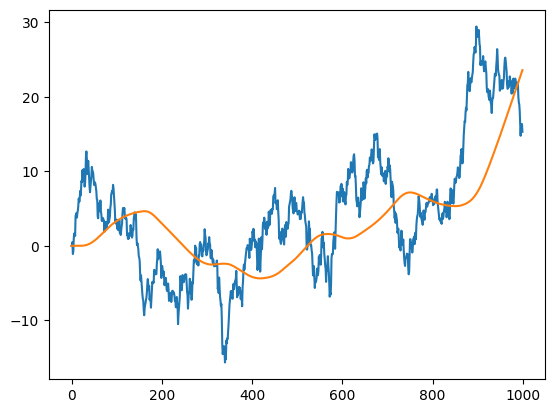

In [8]:
plt.plot(x[0, :, 0], label='Target Position')
plt.plot(x[0, :, 1], label='Cursor Position')